In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
# from gradio_demo.model.utils import output_conv_size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device is: {device}")


/teamspace/studios/this_studio/ml-deploy/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current device is: cuda


Loading the dataset
---

#### Without data augmentation

In [2]:
dataset = load_dataset("Xenova/quickdraw-small")

preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((0,), (1,))
    ]
)

def preprocess_ops(examples):
    examples["image"] = [preprocess(image) for image in examples["image"]]
    return examples

dataset.set_transform(preprocess_ops)

train_dataset, test_dataset, val_dataset = (
    dataset["train"],
    dataset["test"],
    dataset["valid"],
)
train_dataset = train_dataset.shard(num_shards=3, index=0)

#### With data augmentation

In [2]:
dataset = load_dataset("Xenova/quickdraw-small")

train_transforms = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)), 
    transforms.ToTensor(),
])

# Validation/Test: No random changes, just format
eval_transforms = transforms.Compose([
    transforms.ToTensor(),
])

def preprocess_train(examples):
    # Apply the "noisy" transforms to the list of images
    examples["image"] = [train_transforms(image) for image in examples["image"]]
    return examples

def preprocess_eval(examples):
    # Apply the "clean" transforms
    examples["image"] = [eval_transforms(image) for image in examples["image"]]
    return examples


train_dataset = dataset["train"]
test_dataset  = dataset["test"]
val_dataset   = dataset["valid"]

train_dataset = train_dataset.shard(num_shards=3, index=0)

# 6. Apply the transforms to the specific splits
train_dataset.set_transform(preprocess_train)
test_dataset.set_transform(preprocess_eval)
val_dataset.set_transform(preprocess_eval)

In [3]:
names = train_dataset.features["label"].names
n_classes = len(names)
print(f"size of trainset: {len(train_dataset)}, testset: {len(test_dataset)}")

size of trainset: 1500000, testset: 250000


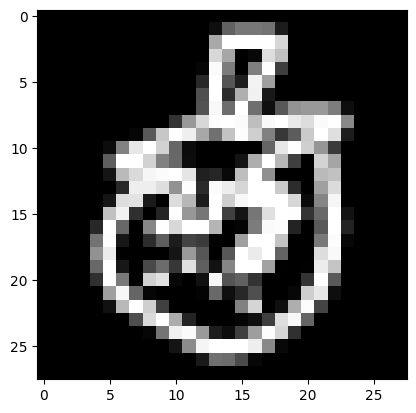

In [4]:
import json

with open("labels.json", "w") as f:
    json.dump(names, f)


def id_to_class(idx):
    return names[idx]


# visualizing an example
idx = torch.randint(0, 100, (1,))
img, label = test_dataset[idx]["image"], test_dataset[idx]["label"]
img = img[0].squeeze(dim=0)
plt.imshow(img, cmap="gray")

Model architecture
---

In [5]:
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device is: {device}")


class CNN(nn.Module):
    def __init__(
        self,
        n_filters,
        hidden_dim,
        n_layers,
        n_classes,
        input_shape=(1, img.shape[0], img.shape[1]),
        dropout_rate=0.5,
    ):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, n_filters, 3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(n_filters, 2 * n_filters, 3, padding=1),
            nn.BatchNorm2d(2 * n_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(2 * n_filters, 4 * n_filters, 3, padding=1),
            nn.BatchNorm2d(4 * n_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # self.conv1 = nn.Conv2d(1, n_filters, conv_kernel_size)
        # self.relu1 = nn.ReLU()
        # self.maxpool1 = nn.MaxPool2d(maxpool_kernel_size)
        # self.conv2 = nn.Conv2d(n_filters, 2*n_filters, conv_kernel_size)
        # self.relu2 = nn.ReLU()
        # self.maxpool2 = nn.MaxPool2d(maxpool_kernel_size)
        # self.input_dim = output_conv_size(img.shape[0], img.shape[1],conv_kernel_size=conv_kernel_size,maxpool_kernel_size=maxpool_kernel_size,n_filters=n_filters)#960

        self.flatten = nn.Flatten()
        dummy_input = torch.zeros(1, *input_shape)
        conv_out_size = self._get_flat_size(dummy_input)
        # print(conv_out_size)
        self.input_dim = conv_out_size # 1080  # 2940#1500 # 960
        self.inp_layer = nn.Linear(self.input_dim, hidden_dim)
        self.classifier = nn.ModuleList()
        for _ in range(n_layers):
            self.classifier.append(
                nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.BatchNorm1d(hidden_dim),
                    nn.ReLU(),
                    nn.Dropout(p=dropout_rate),
                )
            )
        self.out_layer = nn.Linear(hidden_dim, n_classes)

    def _get_flat_size(self, x):
        """Helper class to get the flat size of the input after convolutions"""
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return int(np.prod(x.size()))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.inp_layer(torch.flatten(x, start_dim=1))
        for layer in self.classifier:
            x = layer(x)
        x = self.out_layer(x)
        return x

Current device is: cuda


In [6]:
params = {"n_filters": 30, "hidden_dim": 256, "n_layers": 2, "n_classes": n_classes, "dropout_rate": 0.3}
model = CNN(**params).to(device)
n_params = sum([p.numel() for p in model.parameters()])
print(f"Number of params {n_params}")

Number of params 579909


In [7]:
# hyperparameters
lr = 1e-3
batch_size = 512
n_epochs = 6
num_workers = 40

# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

trainLoader, testLoader = (
    DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers),
    DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers),
)

/teamspace/studios/this_studio/ml-deploy/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if val_loss < (self.best_loss - self.min_delta):
            # Loss improved! Save the model state and reset counter
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            # Loss didn't improve enough
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def load_best_weights(self, model):
        """Restores the model weights from the epoch with the best loss"""
        if self.best_model_state:
            model.load_state_dict(self.best_model_state)
            print(f"Restored best model with loss: {self.best_loss:.4f}")

Training loop
---

In [ ]:
# def train(model, trainLoader, testLoader, criterion, optimizer, n_epochs, device):
#     train_losses = []
#     train_accs = []
#     test_losses = []
#     test_accs = []
#     for epoch in range(1, n_epochs + 1):
#         model.train()
#         train_loss = 0
#         train_acc = 0
#         for batch in tqdm(trainLoader):
#             data, labels = batch["image"].to(device), batch["label"].to(device)
#             out = model(data)
#             preds = out.argmax(dim=1)
#             loss = criterion(out, labels)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#             train_acc += (preds == labels).sum().item()

#         train_loss /= len(trainLoader)
#         train_acc /= len(trainLoader.dataset)
#         train_accs.append(train_acc)
#         train_losses.append(train_loss)

#         model.eval()
#         test_loss = 0
#         test_acc = 0
#         with torch.no_grad():
#             for batch in tqdm(testLoader, disable=True):
#                 data, labels = batch["image"].to(device), batch["label"].to(device)
#                 out = model(data)
#                 loss = criterion(out, labels)
#                 preds = out.argmax(dim=1)
#                 test_loss += loss.item()
#                 test_acc += (preds == labels).sum().item()

#         test_loss /= len(testLoader)
#         test_acc /= len(testLoader.dataset)
#         test_accs.append(test_acc)
#         test_losses.append(test_loss)

#         print(
#             f"epoch {epoch} | train loss {train_loss:.3f} train acc {train_acc:.2f} | test loss {test_loss:.3f} test acc {test_acc:.2f}"
#         )
#     return train_losses, train_accs, test_losses, test_accs

In [ ]:
def train(
    model, trainLoader, testLoader, criterion, optimizer, n_epochs, device, patience=5
):
    train_losses, train_accs, test_losses, test_accs = [], [], [], []

    # early_stopper = EarlyStopping(patience=patience, min_delta=0.001)

    for epoch in range(1, n_epochs + 1):
        # -------------------------
        # 🔹 TRAINING PHASE
        # -------------------------
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        progress = tqdm(trainLoader, desc=f"Epoch {epoch}/{n_epochs}", leave=False)

        for batch in progress:
            data, labels = batch["image"].to(device), batch["label"].to(device)
            out = model(data)
            loss = criterion(out, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = out.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()

            # update tqdm bar
            progress.set_postfix(
                {
                    "train_loss": f"{running_loss / (total / labels.size(0)):.4f}",
                    "train_acc": f"{correct / total:.3f}",
                }
            )

        # compute final training stats for the epoch
        train_loss = running_loss / len(trainLoader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # -------------------------
        # 🔹 VALIDATION PHASE
        # -------------------------
        model.eval()
        test_loss, test_correct, test_total = 0.0, 0, 0

        with torch.no_grad():
            for batch in testLoader:
                data, labels = batch["image"].to(device), batch["label"].to(device)
                out = model(data)
                loss = criterion(out, labels)

                preds = out.argmax(dim=1)
                test_correct += (preds == labels).sum().item()
                test_total += labels.size(0)
                test_loss += loss.item()

        test_loss /= len(testLoader)
        test_acc = test_correct / test_total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        # -------------------------
        # 🔹 SUMMARY PRINT
        # -------------------------
        print(
            f"✅ Epoch {epoch}/{n_epochs} completed | "
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | "
            f"Test Loss: {test_loss:.4f} Acc: {test_acc:.3f}"
        )

        # -------------------------
        # 🔹 EARLY STOPPING CHECK
        # -------------------------
        # early_stopper(test_loss, model)

        # if early_stopper.early_stop:
        #     print(f"🛑 Early stopping triggered at epoch {epoch}!")
        #     break
        # early_stopper.load_best_weights(model)

    return train_losses, train_accs, test_losses, test_accs

In [10]:
train_losses, train_accs, test_losses, test_accs = train(
    model, trainLoader, testLoader, criterion, optimizer, n_epochs, device, patience=5
)

✅ Epoch 1/6 completed | Train Loss: 2.4219 Acc: 0.446 | Test Loss: 1.8066 Acc: 0.570
Restored best model with loss: 1.8066


✅ Epoch 2/6 completed | Train Loss: 1.9377 Acc: 0.540 | Test Loss: 1.6321 Acc: 0.606
Restored best model with loss: 1.6321


✅ Epoch 3/6 completed | Train Loss: 1.8355 Acc: 0.561 | Test Loss: 1.5722 Acc: 0.619
Restored best model with loss: 1.5722


✅ Epoch 4/6 completed | Train Loss: 1.7771 Acc: 0.574 | Test Loss: 1.5308 Acc: 0.628
Restored best model with loss: 1.5308


✅ Epoch 5/6 completed | Train Loss: 1.7376 Acc: 0.583 | Test Loss: 1.4909 Acc: 0.637
Restored best model with loss: 1.4909


✅ Epoch 6/6 completed | Train Loss: 1.7082 Acc: 0.589 | Test Loss: 1.4818 Acc: 0.639
Restored best model with loss: 1.4818


In [11]:
torch.save(model.state_dict(), "weights/cnn_3_conv.pth")